# N-Naive Bayes

This notebook demonstrates the testing for the N-naive-Bayes project. The source for the classifiers can be found in the `models/` directory.

 - `models/nnb_base`: The base class for NNB, containing fitting and prediction generation
 - `models/nnb_parity`: The statistical parity version of NNB
 - `models/nnb_df`: The differential fairness version of NNB
 - `models/two_naive_bayes`: A scikit-Learn implementation of the original CV2NB
 - `models/gaussian_sub`: The Gaussian naive Bayes sub-estimator

Supporting code:
 - `dataset.py`: Classes for interacting with the US Census data. See the [folktables library](https://github.com/zykls/folktables)
 - `scoring.py`: Scoring functions implementing various popular group-fairness measures


## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import sys
import logging
from IPython.display import display
logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s"
)
sns.set_theme(style="darkgrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

In [2]:
sys.path.append('models')

%load_ext autoreload
%autoreload 1
%aimport dataset, scoring, plots, nnb_parity, nnb_df, two_naive_bayes

from scoring import split_preserve_groups, score_table, score_means, split_ds
from dataset import Income, Employment, init_data_src, SensitiveAttr
from plots import compare_groups, group_comparison_barplot, group_comparison_multiplot
from nnb_parity import NNB_Parity
from nnb_df import NNB_DF
from two_naive_bayes import TwoNaiveBayes

In [3]:
try:
    DATA = {
        '2018':init_data_src('2018')
    }
except FileNotFoundError:
    warnings.warn('If on windows, you must download the file manually: https://www2.census.gov/programs-surveys/acs/data/pums/')

In [4]:
def log(l):
    logging.getLogger("nnb_parity").setLevel(l)
    logging.getLogger("nnb_df").setLevel(l)
    logging.getLogger("two_naive_bayes").setLevel(l)

We will store the classification tasks in these globals:

In [5]:
income_race = Income().load(DATA['2018'])
income_racesex = Income(sensitive=SensitiveAttr.RACESEX).load(DATA['2018'])
employment_race = Employment().load(DATA['2018'])
employment_racesex = Employment(sensitive=SensitiveAttr.RACESEX).load(DATA['2018'])

## Testing

For each dataset, we pick sensitive attributes: Race, Sex, or Both (Race-Sex). These will be the classification tasks.

For each classification task, we train a baseline (Gaussian NB), Two-naive-Bayes, and the N-naive-Bayes variants. We present the mean and variance of the scores achieved over `n_splits` (defined below) random train-test splits.

In [6]:
n_splits=10

### Income-Race

Data: Age, class of worker, marital status, relationship, educational attainment, occupation, place of birth, usual hours worked per week.

Aim: To predict whether each individual's income is above $50.000

Sensitive Feature(s) Being Tested: Race

In [7]:
log(logging.ERROR)
score_means(income_race, n_splits=n_splits, classifiers_cat = {
    "GaussianNB":GaussianNB(),
    "NNB-Parity":NNB_Parity(delta=0.05, max_iter=1000, disc_threshold=1e-3),
    "NNB-DF":NNB_DF(delta=0.05, max_iter=1000, disc_threshold=1e-3),
}, classifiers_bin = {
    "GaussianNB_Binary":GaussianNB(),
    "2NB":TwoNaiveBayes(delta=0.05, max_iter=1000, disc_threshold=1e-3)
}, output_order=["Perfect", "GaussianNB_Binary", "2NB", "GaussianNB", "NNB-Parity", "NNB-DF"], include_perfect=True)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Perfect          GaussianNB_Binary               2NB           \
              Mean      Var              Mean      Var     Mean      Var   
Metric                                                                     
AUC        1.00000  0.00000           0.82816  0.00001  0.82223  0.00001   
Accuracy   1.00000  0.00000           0.75101  0.00000  0.75550  0.00000   
DIAvgAll   0.70280  0.00066           0.66269  0.00057  0.91776  0.00161   
EDF-amp    0.00000  0.00000           0.14041  0.00747 -0.01601  0.00766   
EDF-ratio  0.38856  0.00104           0.33657  0.00003  0.39357  0.00005   
EDF-ε      0.94863  0.00768           1.08904  0.00023  0.93262  0.00030   
Parity     0.29246  0.00021           0.36416  0.00001  0.35688  0.00002   

          GaussianNB          NNB-Parity            NNB-DF           
                Mean      Var       Mean      Var     Mean      Var  
Metric                                                               
AUC          0.82705  0.00001    0.80861  0.00001  0.81394  0.00000  
Accuracy     0.75036  0.00000    0.74492  0.00000  0.73380  0.00000  
DIAvgAll     0.64635  0.00040    1.16500  0.00285  1.06967  0.00192  
EDF-amp      0.46041  0.00899   -0.44268  0.00825 -0.68391  0.00280  
EDF-ratio    0.24442  0.00003    0.60457  0.00209  0.76838  0.00163  
EDF-ε        1.40905  0.00042    0.50595  0.00617  0.26472  0.00280  
Parity       0.42120  0.00001    0.22776  0.00067  0.13584  0.00053

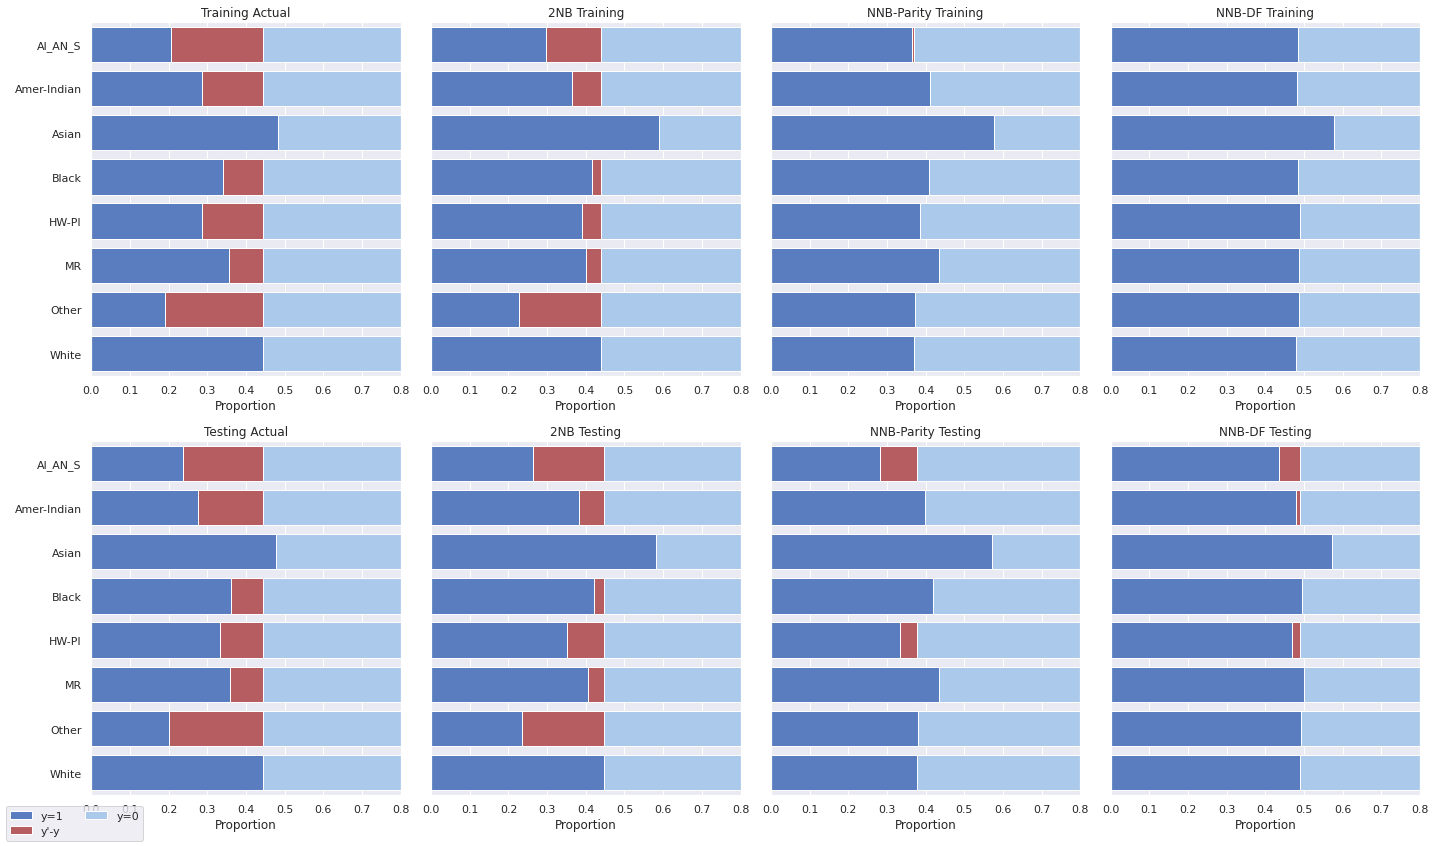

In [8]:
compare_groups(
    *split_ds(income_race), 
    classifiers_cat={
        "NNB-Parity": NNB_Parity(delta=0.05, max_iter=1000, disc_threshold=1e-2), 
        "NNB-DF": NNB_DF(delta=0.05, max_iter=1000, disc_threshold=1e-2), 
    }, classifiers_bin={
        "2NB": TwoNaiveBayes(delta=0.05, max_iter=1000, disc_threshold=1e-2),
    },
    rows=2, cols=4, include_actual=True, axis_lim=(0.0, 0.8))

### Employment-Race

Data: Age, educational attainment, marital status, relationship, disability, employment status of parents, citizenship status, mobility status, military service, ancestry, nativity, hearing difficulty, vision difficulty, cognitive difficulty.

Aim: To predict whether each individual is currently employed

Sensitive Feature(s) Being Tested: Race

In [9]:
log(logging.ERROR)
score_means(employment_race, n_splits=n_splits, classifiers_cat = {
    "GaussianNB":GaussianNB(),
    "NNB-Parity":NNB_Parity(delta=0.05, max_iter=1000, disc_threshold=1e-3),
    "NNB-DF":NNB_DF(delta=0.05, max_iter=1000, disc_threshold=1e-3),
}, classifiers_bin = {
    "GaussianNB_Binary":GaussianNB(),
    "2NB":TwoNaiveBayes(delta=0.05, max_iter=1000, disc_threshold=1e-3)
}, output_order=["Perfect", "GaussianNB_Binary", "2NB", "GaussianNB", "NNB-Parity", "NNB-DF"], include_perfect=True)

100%|██████████| 10/10 [03:26<00:00, 20.67s/it]


Perfect          GaussianNB_Binary               2NB           \
              Mean      Var              Mean      Var     Mean      Var   
Metric                                                                     
AUC        1.00000  0.00000           0.81334  0.00000  0.81082  0.00000   
Accuracy   1.00000  0.00000           0.72752  0.00000  0.72805  0.00000   
DIAvgAll   0.93488  0.00015           0.95262  0.00008  0.93921  0.00008   
EDF-amp    0.00000  0.00000           0.11953  0.00028  0.11980  0.00025   
EDF-ratio  0.73840  0.00015           0.65517  0.00005  0.65498  0.00004   
EDF-ε      0.30339  0.00027           0.42292  0.00011  0.42319  0.00010   
Parity     0.12926  0.00005           0.25570  0.00003  0.25360  0.00002   

          GaussianNB          NNB-Parity            NNB-DF           
                Mean      Var       Mean      Var     Mean      Var  
Metric                                                               
AUC          0.81319  0.00000    0.79117  0.00000  0.78900  0.00000  
Accuracy     0.72749  0.00000    0.73645  0.00000  0.73275  0.00000  
DIAvgAll     0.95255  0.00008    1.25416  0.00036  1.06139  0.00015  
EDF-amp      0.12126  0.00027    0.03237  0.00038 -0.15149  0.00015  
EDF-ratio    0.65403  0.00005    0.71488  0.00014  0.85925  0.00033  
EDF-ε        0.42465  0.00012    0.33576  0.00027  0.15190  0.00046  
Parity       0.25657  0.00003    0.20342  0.00011  0.10047  0.00019

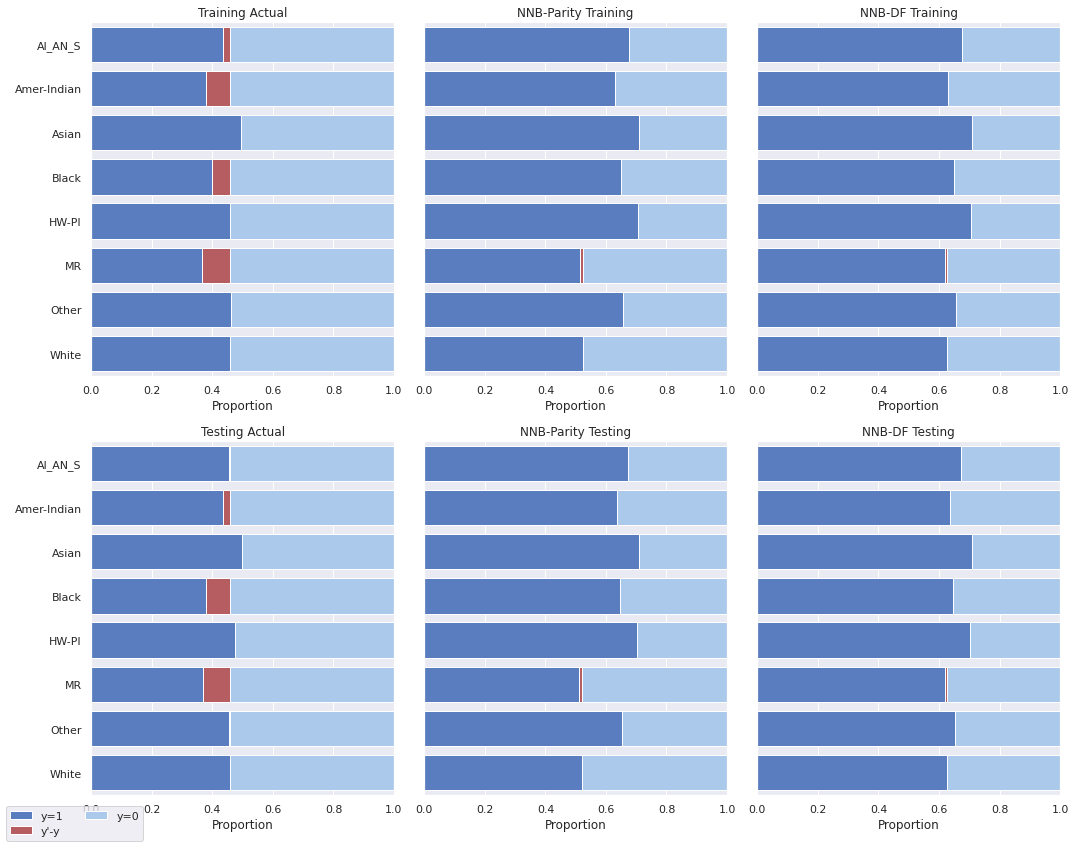

In [10]:
compare_groups(
    *split_ds(employment_race), 
    classifiers_cat={
        "NNB-Parity": NNB_Parity(delta=0.05, max_iter=1000, disc_threshold=1e-2), 
        "NNB-DF": NNB_DF(delta=0.05, max_iter=1000, disc_threshold=1e-2), 
    }, 
    rows=2, cols=3, include_actual=True)

### Income-Race-Sex

Data: Age, class of worker, marital status, relationship, educational attainment, occupation, place of birth, usual hours worked per week.

Aim: To predict whether each individual's income is above $50.000

Sensitive Feature(s) Being Tested: Race, Sex

In [11]:
log(logging.ERROR)
score_means(income_racesex, n_splits=n_splits, classifiers_cat = {
    "GaussianNB":GaussianNB(),
    "NNB-Parity":NNB_Parity(delta=0.05, max_iter=1000, disc_threshold=1e-3),
    "NNB-DF":NNB_DF(delta=0.05, max_iter=1000, disc_threshold=1e-3),
}, classifiers_bin = {
    "GaussianNB_Binary":GaussianNB(),
    "2NB":TwoNaiveBayes(delta=0.05, max_iter=1000, disc_threshold=1e-3)
}, output_order=["Perfect", "GaussianNB_Binary", "2NB", "GaussianNB", "NNB-Parity", "NNB-DF"], include_perfect=True)

100%|██████████| 10/10 [00:47<00:00,  4.71s/it]


Perfect          GaussianNB_Binary               2NB           \
              Mean      Var              Mean      Var     Mean      Var   
Metric                                                                     
AUC        1.00000  0.00000           0.83240  0.00000  0.82308  0.00000   
Accuracy   1.00000  0.00000           0.75520  0.00000  0.75416  0.00000   
DIAvgAll   0.63138  0.00019           0.64875  0.00009  0.86625  0.00029   
EDF-amp    0.00000  0.00000          -0.12176  0.00180 -0.13623  0.00106   
EDF-ratio  0.26212  0.00005           0.29609  0.00009  0.30036  0.00006   
EDF-ε      1.33929  0.00078           1.21753  0.00099  1.20306  0.00065   
Parity     0.39315  0.00009           0.40196  0.00004  0.40502  0.00004   

          GaussianNB          NNB-Parity            NNB-DF           
                Mean      Var       Mean      Var     Mean      Var  
Metric                                                               
AUC          0.82690  0.00000    0.79966  0.00000  0.81579  0.00000  
Accuracy     0.74996  0.00000    0.73453  0.00000  0.72446  0.00000  
DIAvgAll     0.66694  0.00009    1.33731  0.00125  1.03458  0.00056  
EDF-amp      0.15658  0.00246   -0.54522  0.01890 -0.99246  0.01256  
EDF-ratio    0.22422  0.00008    0.45534  0.00315  0.71040  0.00525  
EDF-ε        1.49587  0.00167    0.79407  0.01694  0.34683  0.01115  
Parity       0.44573  0.00006    0.33359  0.00108  0.18031  0.00186

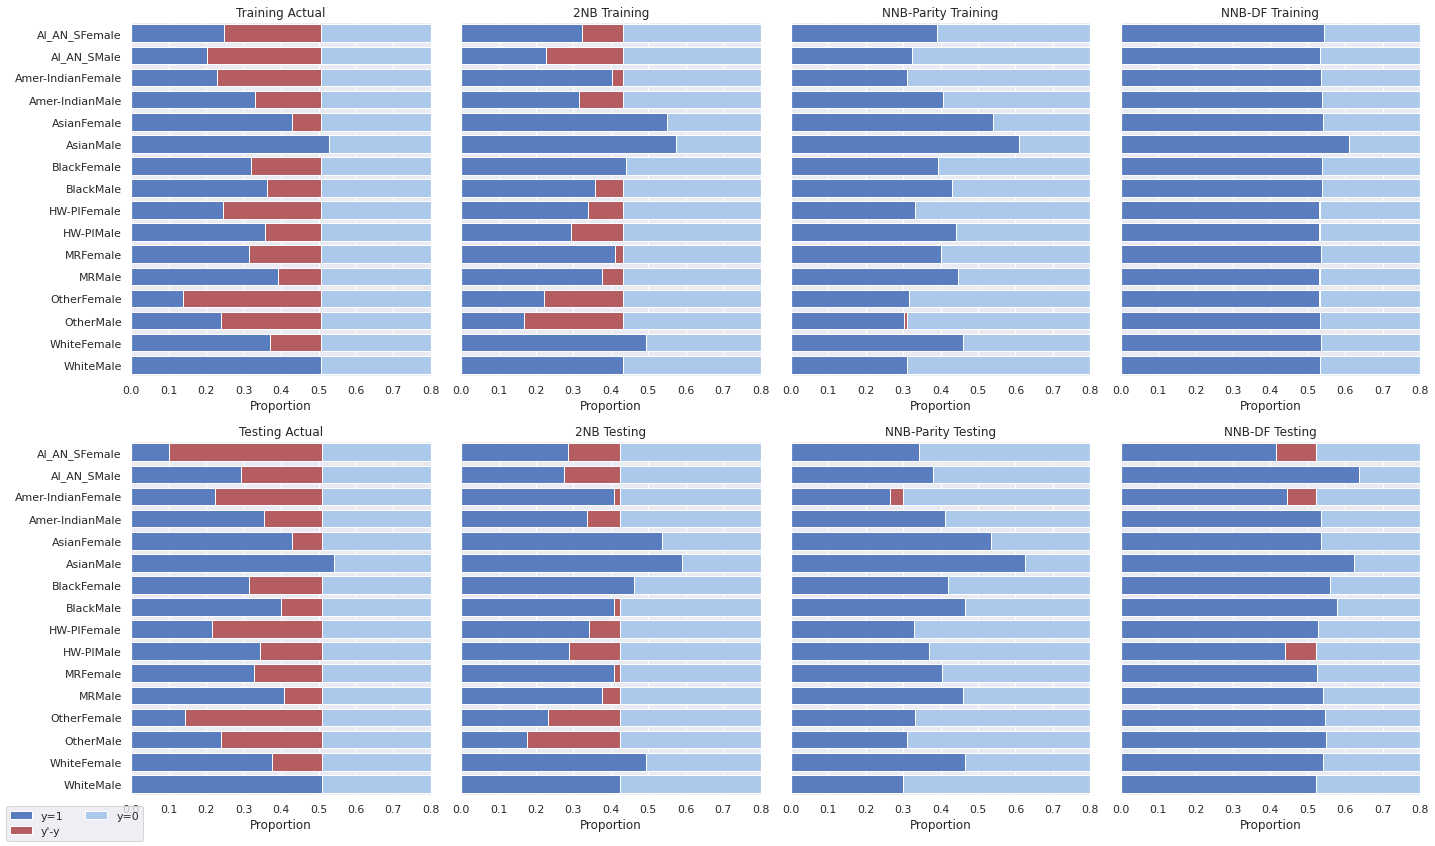

In [12]:
compare_groups(
    *split_ds(income_racesex), 
    classifiers_cat={
        "NNB-Parity": NNB_Parity(delta=0.05, max_iter=1000, disc_threshold=1e-2), 
        "NNB-DF": NNB_DF(delta=0.05, max_iter=1000, disc_threshold=1e-2), 
    }, classifiers_bin={
        "2NB": TwoNaiveBayes(delta=0.05, max_iter=1000, disc_threshold=1e-2)
    }, 
    rows=2, cols=4, include_actual=True, axis_lim=(0.0, 0.8))

### Employment-Race-Sex

Data: Age, educational attainment, marital status, relationship, disability, employment status of parents, citizenship status, mobility status, military service, ancestry, nativity, hearing difficulty, vision difficulty, cognitive difficulty.

Aim: To predict whether each individual is currently employed

Sensitive Feature(s) Being Tested: Race, Sex

In [13]:
log(logging.ERROR)
score_means(employment_racesex, n_splits=n_splits, classifiers_cat = {
    "GaussianNB":GaussianNB(),
    "NNB-Parity":NNB_Parity(delta=0.05, max_iter=1000, disc_threshold=1e-3),
    "NNB-DF":NNB_DF(delta=0.2, max_iter=1000, disc_threshold=1e-3),
}, classifiers_bin = {
    "GaussianNB_Binary":GaussianNB(),
    "2NB":TwoNaiveBayes(delta=0.05, max_iter=1000, disc_threshold=1e-3)
}, output_order=["Perfect", "GaussianNB_Binary", "2NB", "GaussianNB", "NNB-Parity", "NNB-DF"], include_perfect=True)

100%|██████████| 10/10 [03:30<00:00, 21.05s/it]


Perfect          GaussianNB_Binary               2NB           \
              Mean      Var              Mean      Var     Mean      Var   
Metric                                                                     
AUC        1.00000  0.00000           0.81588  0.00000  0.80840  0.00000   
Accuracy   1.00000  0.00000           0.72737  0.00000  0.72660  0.00000   
DIAvgAll   0.86632  0.00033           1.02496  0.00010  0.93527  0.00011   
EDF-amp    0.00000  0.00000           0.11435  0.00046  0.10569  0.00047   
EDF-ratio  0.67555  0.00022           0.60251  0.00011  0.60776  0.00012   
EDF-ε      0.39244  0.00047           0.50679  0.00030  0.49813  0.00034   
Parity     0.17094  0.00006           0.30282  0.00007  0.29874  0.00008   

          GaussianNB          NNB-Parity            NNB-DF           
                Mean      Var       Mean      Var     Mean      Var  
Metric                                                               
AUC          0.81334  0.00000    0.78397  0.00000  0.79353  0.00000  
Accuracy     0.72724  0.00000    0.72592  0.00000  0.72509  0.00000  
DIAvgAll     1.03024  0.00011    1.30394  0.00031  1.06483  0.00020  
EDF-amp      0.11609  0.00048    0.02414  0.00169 -0.17111  0.00123  
EDF-ratio    0.60146  0.00011    0.65982  0.00075  0.80213  0.00117  
EDF-ε        0.50853  0.00030    0.41658  0.00179  0.22133  0.00189  
Parity       0.30392  0.00007    0.25835  0.00086  0.15090  0.00088

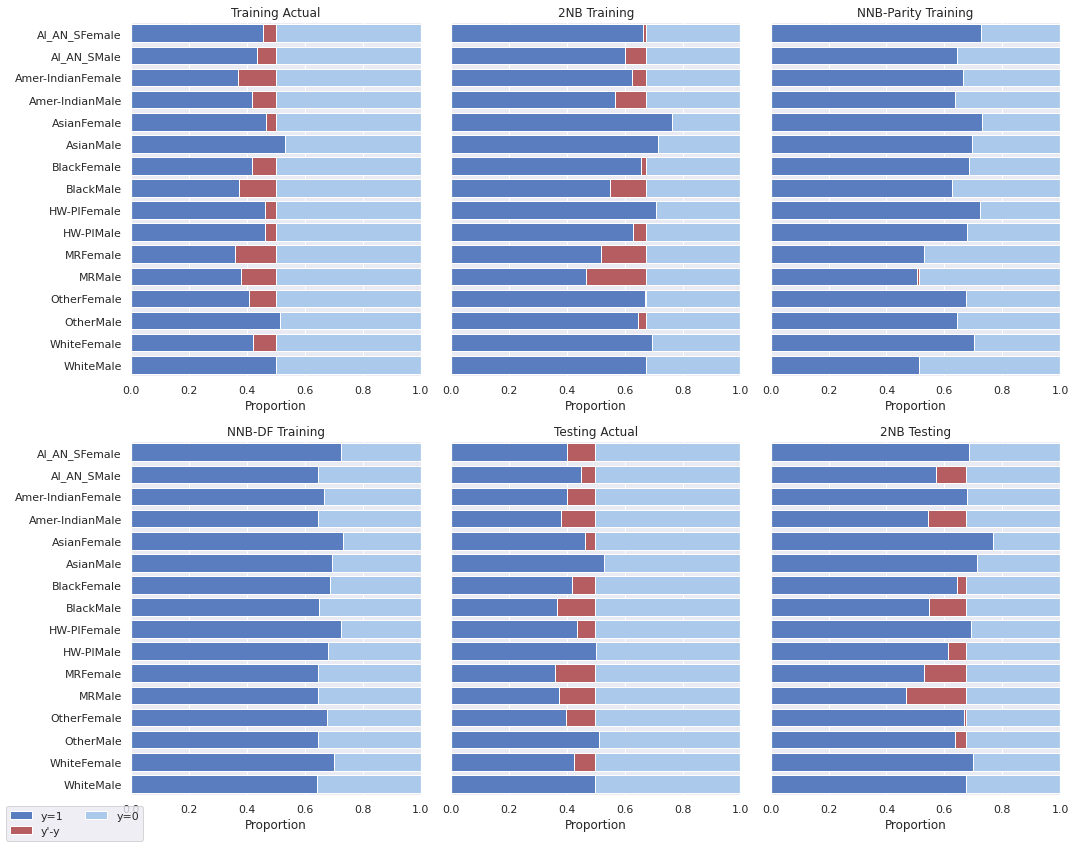

In [14]:
log(logging.ERROR)
compare_groups(
    *split_ds(employment_racesex), 
    classifiers_cat={
        "NNB-Parity": NNB_Parity(delta=0.05, max_iter=1000, disc_threshold=1e-2), 
        "NNB-DF": NNB_DF(delta=0.2, max_iter=1000, disc_threshold=1e-2), 
    }, classifiers_bin={
        "2NB": TwoNaiveBayes(delta=0.05, max_iter=1000, disc_threshold=1e-3)
    }, 
    rows=2, cols=3, include_actual=True)